In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

## Air quality data

We can obtain hourly data of the particle concentrations measured at multiple locations in Berlin from a server maintained by the city council. 

In [2]:
air_ql_df = pd.read_csv('ber_mc143_20171120-20181121.csv', sep=';', header=1, skiprows=[2,3])
air_ql_df.rename(columns={'Messkomponente':'Time'}, inplace=True)

In [3]:
air_ql_df.head()

,Time,Feinstaub (PM10),Stickstoffmonoxid,Stickstoffdioxid,Stickoxide
0,20.11.2017 01:00,13.0,1.0,12.0,14.0
1,20.11.2017 02:00,9.0,1.0,10.0,11.0
2,20.11.2017 03:00,9.0,1.0,10.0,12.0
3,20.11.2017 04:00,9.0,2.0,14.0,17.0
4,20.11.2017 05:00,10.0,5.0,23.0,30.0


Let's change the time to the pandas 'datetime' format and interpolate for missing data points.

In [4]:
air_ql_df['Time'] = pd.to_datetime(air_ql_df['Time'])

In [5]:
air_ql_df.interpolate(inplace=True)

## Climate data

Data on air temperature and humidity can be obtained from 

In [6]:
air_temp_df = pd.read_csv('produkt_air_temperature_399_akt.txt', sep=';', header=0, skiprows=[])

In [7]:
air_temp_df.columns = air_temp_df.columns.str.strip()
air_temp_df.rename(columns={'MESS_DATUM':'Time'},inplace=True)
air_temp_df.drop(columns=['STATIONS_ID', 'STRUKTUR_VERSION', 'eor'], inplace=True)

Some values are for some reason -100°C, indicating an error. We replace this value with the average between the preceding and following value.

In [8]:
ind_low = air_temp_df[air_temp_df['LUFTTEMPERATUR'] < -100].index

for i in ind_low:
    new = (air_temp_df['LUFTTEMPERATUR'][i-1] + air_temp_df['LUFTTEMPERATUR'][i+1]) / 2
    air_temp_df['LUFTTEMPERATUR'][i] = new 

/Users/hannokupers/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [9]:
air_temp_df.head()

,Time,QUALITAETS_NIVEAU,LUFTTEMPERATUR,REL_FEUCHTE
0,2015082001,2,15.9,92
1,2015082002,2,15.2,93
2,2015082003,2,14.8,87
3,2015082004,2,14.6,70
4,2015082005,2,15.0,63


As we see it is for the last three years.

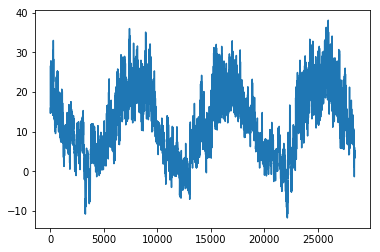

In [10]:
air_temp_df['LUFTTEMPERATUR'].plot()

Also here, we change the time to 'datetime'

In [11]:
air_temp_df['Time'] = pd.to_datetime(air_temp_df['Time'], format='%Y%m%d%H')

## Complete data

By doing an inner join of the two tables we can get a combined table.

In [12]:
air_df = pd.merge(air_ql_df, air_temp_df, on='Time', how='inner')
#air_df.set_index('Time',inplace=True)

In [13]:
air_df.head()

,Time,Feinstaub (PM10),Stickstoffmonoxid,Stickstoffdioxid,Stickoxide,QUALITAETS_NIVEAU,LUFTTEMPERATUR,REL_FEUCHTE
0,2017-11-20 01:00:00,13.0,1.0,12.0,14.0,2,3.2,81
1,2017-11-20 02:00:00,9.0,1.0,10.0,11.0,2,2.9,78
2,2017-11-20 03:00:00,9.0,1.0,10.0,12.0,2,2.7,78
3,2017-11-20 04:00:00,9.0,2.0,14.0,17.0,2,3.3,88
4,2017-11-20 05:00:00,10.0,5.0,23.0,30.0,2,4.0,92


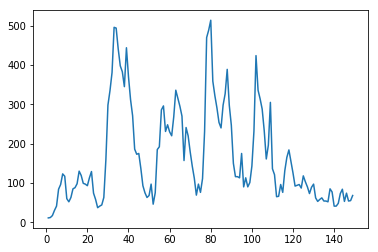

In [14]:
air_df['Stickoxide'][1:150].plot()

(array([2.453e+03, 2.340e+03, 1.264e+03, 9.110e+02, 5.680e+02, 3.760e+02,
        2.290e+02, 1.520e+02, 8.000e+01, 5.700e+01, 3.300e+01, 1.400e+01,
        5.000e+00, 6.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00]),
 array([  6. ,  54.6, 103.2, 151.8, 200.4, 249. , 297.6, 346.2, 394.8,
        443.4, 492. , 540.6, 589.2, 637.8, 686.4, 735. , 783.6, 832.2,
        880.8, 929.4, 978. ]),
 <a list of 20 Patch objects>)

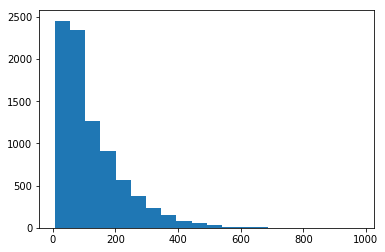

In [15]:
plt.hist(air_df['Stickoxide'].values, bins=20)

# Autocorrelation

For time series, an important point is something called autocorrelation, which is reflecting how much a value is similiar to a value that is one, two, or many time steps before the value. Pandas has an integrated 'autocorrelation_plot', which is doing everything for us. It shows the amount of correlation for different values of lag, meaning time difference between two datapoints.

In [16]:
data = air_df['Stickoxide']

(0, 168)

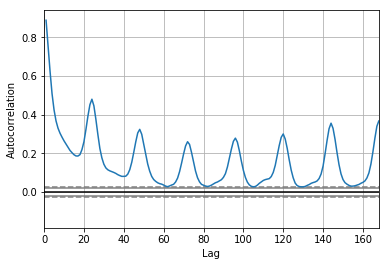

In [17]:
from pandas.plotting import autocorrelation_plot
fig, ax = plt.subplots()
autocorrelation_plot(data, ax=ax)
ax.set_xlim(0,24*7)

In the autocorrelation plot we see that there exists an autocorrelation for lags of multiples of 24 hours. This is a kind of seasonality effect, as every the particle density changes over the day and is lowest at night and highest around noon. Therefore, the value now will be more similar to the value 24 hours ago than 12 hours ago.
The autocorrelation plot is also important to investigate how random the behaviour is. For a random walk, there is a fast decay in the autocorrelation for larger lags because every value depends mostly on the preceding value. This randomness can lead to big problems in the analysis of time series. A very nice discussion about these problems can be found at https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424

In [18]:
air_df.corr()

,Feinstaub (PM10),Stickstoffmonoxid,Stickstoffdioxid,Stickoxide,QUALITAETS_NIVEAU,LUFTTEMPERATUR,REL_FEUCHTE
Feinstaub (PM10),1.000000,0.451154,0.514142,0.490846,NaN,0.091266,-0.066576
Stickstoffmonoxid,0.451154,1.000000,0.741383,0.984611,NaN,-0.051345,0.043671
Stickstoffdioxid,0.514142,0.741383,1.000000,0.847140,NaN,0.153426,-0.157293
Stickoxide,0.490846,0.984611,0.847140,1.000000,NaN,-0.000701,-0.006350
QUALITAETS_NIVEAU,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LUFTTEMPERATUR,0.091266,-0.051345,0.153426,-0.000701,NaN,1.000000,-0.620828
REL_FEUCHTE,-0.066576,0.043671,-0.157293,-0.006350,NaN,-0.620828,1.000000


## Data set split

The data set is split in 80% train and 20% test sets and scaled subsequently as recurrent neural networks can be sensitive to scales.

In [19]:
sz_test = 0.2
id_test =  int(round((1-sz_test) * air_df.shape[0]))

data, data_test = air_df['Stickoxide'][:id_test].values, air_df['Stickoxide'][id_test:].values
data_sec, data_sec_test = air_df['LUFTTEMPERATUR'][:id_test].values, air_df['LUFTTEMPERATUR'][id_test:].values


In [20]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler_sec = MinMaxScaler(feature_range=(-1,1))

data = scaler.fit_transform(data.reshape(-1, 1))
data_sec = scaler_sec.fit_transform(data_sec.reshape(-1, 1))

data_test = scaler.transform(data_test.reshape(-1, 1))
data_sec_test = scaler_sec.transform(data_sec_test.reshape(-1, 1))

## Baseline: Persistence model

As randomness can be a problem for time series, we need a good baseline model to test our model against. The persistence model takes the current value as prediction for the following value. For this model we calculate the mean squared error, which will be the loss of our model.

In [21]:
def mse_persistence(data_test):
    mse = (np.sum(np.square(data_test-np.roll(data_test,1))))/len(data_test)
    return mse

In [22]:
print('MSE from persistence model: ', mse_persistence(data_test))

MSE from persistence model:  0.023006094193914674


## Prediction

We feed the model with batches of data that are small sequences, always starting at incrementing time steps.

In [23]:
def next_batch(batch_size, n_steps, id_start, data=data, data_sec=data_sec):
    t0 = np.arange(id_start, id_start+batch_size).reshape(batch_size, 1)#np.random.randint(0, (len(air_df) - n_steps - 2), size=(batch_size, 1))
    Ts = t0 + np.arange(0, n_steps + 1)
    ys = data[Ts]
    ys_sec = data_sec[Ts]
    return np.stack((ys[:, :-1].reshape(batch_size, n_steps), ys_sec[:, :-1].reshape(batch_size, n_steps)), axis=-1), ys[:, 1:].reshape(-1, n_steps, 1)#np.stack((ys[:, :-1], ys_sec[:, :-1]), axis=-1)

The model looks at 50 time steps and uses temperature and current air quality as inputs. The RNN cells contain 100 neurons and give one output, the following value for air quality. The RNN cell (using a gated recurrent unit, GRU) is defined in tensorflow as

In [24]:
tf.reset_default_graph()

n_steps = 100
n_inputs = 2
n_neurons = 50
n_outputs = 1

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_steps, n_outputs])

cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.nn.rnn_cell.LSTMCell(num_units=n_neurons, activation=tf.nn.tanh),
    output_size=n_outputs)
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

The rest of the model involves learning rate (with exponential decay), loss function, which is mean squared error, and the optimizer

In [25]:
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.005
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           100, 0.94, staircase=True)

loss = tf.reduce_mean(tf.square(outputs - y)) # MSE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss, global_step=global_step)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

This model is trained on the training data and the test error is displayed during training

In [26]:
n_epochs = 50
batch_size = 28

with tf.Session() as sess:
    init.run()
    mse_sess, mse_test_sess = [], []
    for epoch in range(n_epochs):
        #train
        for batch in range((data.shape[0]-batch_size-n_steps)//batch_size):
            X_batch, y_batch = next_batch(batch_size, n_steps, batch*batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        #train error
        mse, mse_test = [], []
        for batch in range((data.shape[0]-batch_size-n_steps)//batch_size):
            X_batch, y_batch = next_batch(batch_size, n_steps, batch*batch_size)
            mse_batch = loss.eval(feed_dict={X: X_batch, y: y_batch})
            mse.append(mse_batch)
        #test error    
        for batch in range((data_test.shape[0]-batch_size-n_steps)//batch_size):
            X_batch_test, y_batch_test = next_batch(batch_size, n_steps, batch*batch_size, data=data_test, data_sec=data_sec_test)
            mse_batch = loss.eval(feed_dict={X: X_batch_test, y: y_batch_test})
            mse_test.append(mse_batch)
        globalstep = tf.train.get_global_step()
        step_value = sess.run(global_step)
        print(epoch, "\ttrain MSE:", np.mean(mse), "\ttest MSE:", np.mean(mse_test), step_value)
        mse_sess.append(np.mean(mse))
        mse_test_sess.append(np.mean(mse_test))
    #test prediction
    y_pred = []
    for batch in range(0, data_test.shape[0]//n_steps):
        X_batch_test, y_batch_test = next_batch(1, n_steps, batch*n_steps, data=data_test, data_sec=data_sec_test)
        y_pred_seq = sess.run(outputs, feed_dict={X: X_batch_test})
        y_pred.append(y_pred_seq)
    
    y_pred = np.array(y_pred).reshape((data_test.shape[0])//n_steps*n_steps)
    saver.save(sess, "/tmp/airql_time_series_model")

0 	train MSE: 0.017359216 	test MSE: 0.03214972 238
1 	train MSE: 0.013126773 	test MSE: 0.024050565 476
2 	train MSE: 0.012689672 	test MSE: 0.023037937 714
3 	train MSE: 0.012345199 	test MSE: 0.02230958 952
4 	train MSE: 0.012537912 	test MSE: 0.02223311 1190
5 	train MSE: 0.012440435 	test MSE: 0.022262031 1428
6 	train MSE: 0.012141548 	test MSE: 0.021284888 1666
7 	train MSE: 0.011985195 	test MSE: 0.020866465 1904
8 	train MSE: 0.011912076 	test MSE: 0.02084745 2142
9 	train MSE: 0.011864781 	test MSE: 0.020790806 2380
10 	train MSE: 0.011806711 	test MSE: 0.020838916 2618
11 	train MSE: 0.011703141 	test MSE: 0.020910462 2856
12 	train MSE: 0.011599342 	test MSE: 0.020923253 3094
13 	train MSE: 0.011515765 	test MSE: 0.020908315 3332
14 	train MSE: 0.011411954 	test MSE: 0.020798717 3570
15 	train MSE: 0.011293674 	test MSE: 0.020633196 3808
16 	train MSE: 0.011168952 	test MSE: 0.020432161 4046
17 	train MSE: 0.011039347 	test MSE: 0.02023228 4284
18 	train MSE: 0.010913755 	t

After about 40 epochs the test error is basically constant. In the plot of train and test error over epochs we see that the test error converges at a value of 0.0187, which is only 19% lower than the baseline value for the persistence model of 0.023.

(0, 50)

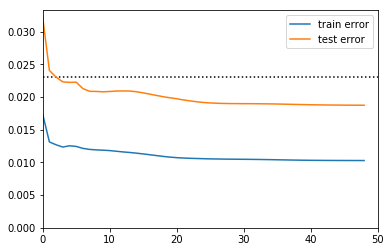

In [27]:
(fig, ax) = plt.subplots()
ax.plot(mse_sess[:-1], label='train error')
ax.plot(mse_test_sess[:-1], label='test error')
ax.legend()
ax.hlines(0.023,0,n_epochs,linestyle='dotted')
ax.set_ylim(0)
ax.set_xlim(0,n_epochs)

Also when we plot a part of the sequence with the prediction for this sequence we see a clear deviation. Here, it is apparent that the model resembles partly the persistence model where the predicted values seem to lag behind 1 time step. If we would look at the data on a large x-scale, this deviation would not be visible and the model result would appear as being incredibly precise. This misinterpretation of the results can be seen for many projects with time series that are available online. Therefore, one always needs to be skeptical about too great results and have robust baselines.
The persistence model is the best model for random walk data. That means either the particle density is similar to a random walk and therefore not predictable up to a certain point, or we are missing the determining parameters. Here, we only used the current value of particle density and temperature. Important parameters may be also wind speed, amount of traffic, humidity...

(1300, 1500)

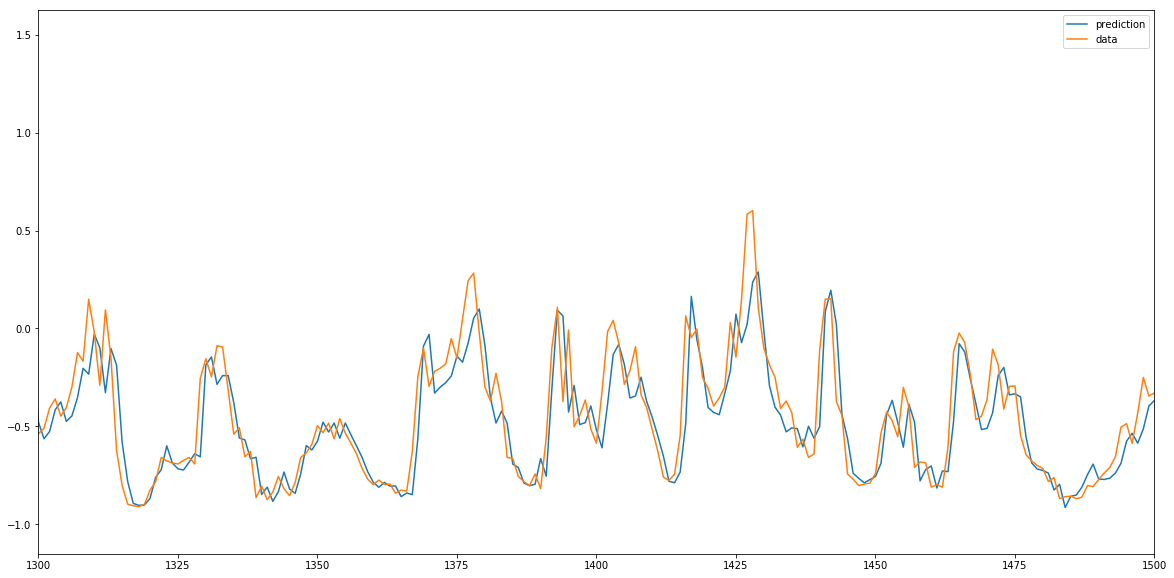

In [28]:
(fig, ax) = plt.subplots(figsize=(20,10))
ax.plot(y_pred, label='prediction')# range(1,n_steps+1),
ax.plot(data_test[1:], label='data')
ax.legend()
ax.set_xlim(1300,1500)
#ax.set_ylim(-1,1)

# Creative prediction

With the RNN model not only the next value can be predicted, the predicted value can be fed to the model again and an entire sequence can be generated.

In [29]:
sequence = data_test[:n_steps]
with tf.Session() as sess:
    saver.restore(sess, "/tmp/airql_time_series_model")
    for iteration in range(100):
        #iteration = 0
        X_batch = np.stack([sequence[-n_steps:], data_sec_test[iteration:n_steps+iteration]], axis=1).reshape(1, n_steps, n_inputs)
        y_pred_cr = sess.run(outputs, feed_dict={X: X_batch})
        sequence = np.append(sequence, y_pred_cr[0, -1, 0]).reshape(-1,1)

INFO:tensorflow:Restoring parameters from /tmp/airql_time_series_model


(-1, 0)

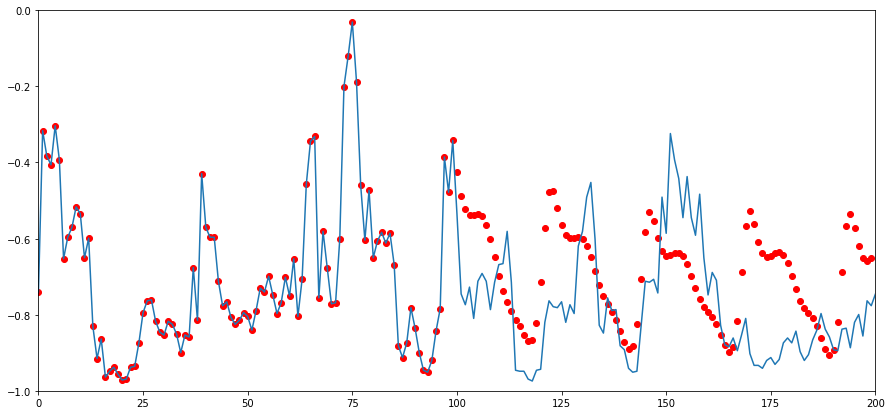

In [30]:
(fig, ax) = plt.subplots(figsize=(15,7))
ax.plot(sequence,'or', label='prediction')
ax.plot(data_test, label='data')
ax.set_xlim(0,200)
ax.set_ylim(-1,0)

Here, we see that the predicted sequence is not very rich. It shows some variance and a clear peak that drops over time every day. However, this structure is just repeated each day. At least, for some days the peak is at the correct time but not magnitude.

## Conclusion

Time series are a good way to understand recurrent neural networks. However, there are serious pitfalls that need to be avoided when evaluating the model and one needs to always stay skeptical of one's own results. For a better performing model we can try to incorporate more parameters like wind and humidity or even change the model to convolutional neural networks, which seem to be on the rise for time series again.